In [1]:
#Importing the Libraries
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df = pd.read_csv("AAPL.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.553025,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.564355,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.459939,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.447999,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.490865,447610800


In [3]:
#Print the shape of Dataframe 
print("Dataframe Shape: ", df.shape)

Dataframe Shape:  (2999, 7)


In [4]:
#Check for null values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
#setting index as date values
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Close'][i] = data['Close'][i]

In [7]:
#create features
from fastai.tabular.core import add_datepart
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp

In [8]:
pd.options.mode.chained_assignment = None  # default='warn'
new_data['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data['mon_fri'][i] = 1
    else:
        new_data['mon_fri'][i] = 0

In [9]:
#split into train and validation
train = new_data[:2770]
valid = new_data[2770:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

# Linear Regression

In [10]:
#implement linear regression   
np.float = float   
np.object = object 
#these 2 are explicitly defined as numpy version>1.23.5 doesn't have float in it and i've 1.24.0
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)


#make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

67.7754538450982

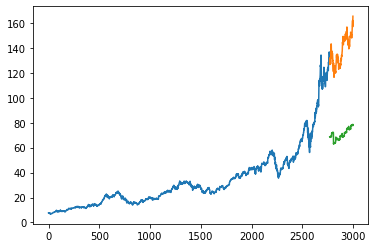

In [11]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = new_data[2770:].index
train.index = new_data[:2770].index

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

# KNN

In [12]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [13]:
#scaling data
np.int=int
np.bool=bool
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

In [14]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms


125.1025536376903

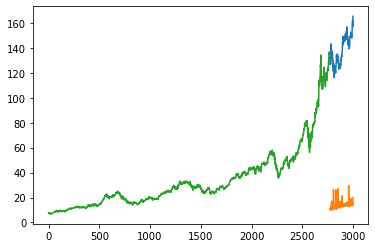

In [15]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])

<!-- # AUTO ARIMA -->

# LSTM

In [16]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:2770,:]
valid = dataset[2770:,:]


In [17]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))



In [20]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, activation='relu',input_shape=(x_train.shape[1],1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)



Epoch 1/100
339/339 [==============================] - 9s 19ms/step - loss: 1.3241e-04
Epoch 2/100
339/339 [==============================] - 6s 19ms/step - loss: 0.0072
Epoch 3/100
339/339 [==============================] - 6s 18ms/step - loss: 0.0049
Epoch 4/100
339/339 [==============================] - 5s 16ms/step - loss: 0.0025
Epoch 5/100
339/339 [==============================] - 6s 18ms/step - loss: 6.3034e-04
Epoch 6/100
339/339 [==============================] - 6s 19ms/step - loss: 1.3818e-04
Epoch 7/100
339/339 [==============================] - 9s 26ms/step - loss: 3.1537e-04
Epoch 8/100
339/339 [==============================] - 14s 43ms/step - loss: 1.3792e-04
Epoch 9/100
339/339 [==============================] - 9s 27ms/step - loss: 1.1882e-04
Epoch 10/100
339/339 [==============================] - 7s 20ms/step - loss: 4.4165e-05
Epoch 11/100
339/339 [==============================] - 6s 18ms/step - loss: 9.9657e-05
Epoch 12/100
339/339 [==============================

In [21]:
#predicting 230 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [22]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

2.311242764434514

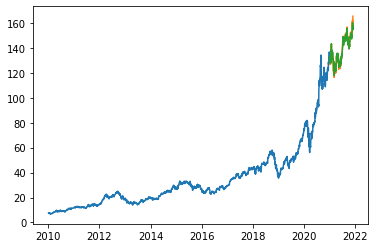

In [23]:
#for plotting
train = new_data[:2770]
valid = new_data[2770:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])